In [1]:
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

After having imported the relevent modules, the next step is to load the data.

In [2]:
data = pd.read_csv('data.csv')
data.head() #see what the data looks like

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,09/02/1966,1966,1,False,Miami Dolphins,14,23,Oakland Raiders,NaN,NaN,NaN,Orange Bowl,False,83.0,6.0,71,NaN
1,09/03/1966,1966,1,False,Houston Oilers,45,7,Denver Broncos,NaN,NaN,NaN,Rice Stadium,False,81.0,7.0,70,NaN
2,09/04/1966,1966,1,False,San Diego Chargers,27,7,Buffalo Bills,NaN,NaN,NaN,Balboa Stadium,False,70.0,7.0,82,NaN
3,09/09/1966,1966,2,False,Miami Dolphins,14,19,New York Jets,NaN,NaN,NaN,Orange Bowl,False,82.0,11.0,78,NaN
4,09/10/1966,1966,1,False,Green Bay Packers,24,3,Baltimore Colts,NaN,NaN,NaN,Lambeau Field,False,64.0,8.0,62,NaN


We want to predict the probability of a team winning given the betting spread using Logistic Regression! This data needs some pre-processing. First, we need to remove the games without spreads

In [3]:
data = data.dropna(subset=["team_favorite_id"])
data.reset_index(drop=True,inplace=True) #this "forgets" that the bad rows even existed
data.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,01/15/1967,1966,Superbowl,True,Green Bay Packers,35,10,Kansas City Chiefs,GB,-14.0,NaN,Los Angeles Memorial Coliseum,True,54.0,7.0,90,NaN
1,01/14/1968,1967,Superbowl,True,Green Bay Packers,33,14,Oakland Raiders,GB,-13.5,43,Orange Bowl,True,60.0,12.0,74,NaN
2,01/12/1969,1968,Superbowl,True,Baltimore Colts,7,16,New York Jets,IND,-18.0,40,Orange Bowl,True,66.0,12.0,80,NaN
3,01/11/1970,1969,Superbowl,True,Kansas City Chiefs,23,7,Minnesota Vikings,MIN,-12.0,39,Tulane Stadium,True,55.0,14.0,84,NaN
4,01/17/1971,1970,Superbowl,True,Baltimore Colts,16,13,Dallas Cowboys,IND,-2.5,36,Orange Bowl,True,59.0,11.0,60,NaN


Unfortunately, the team_favorite_id column uses a different naming system than the team_home and team_away columns. The easiest way to do this is by hand because the number of entries to match is very small. We've provided that conversion for you

In [4]:
conversions = pd.read_csv('conversions.csv')
conversions.head()

,Team,ID
0,Miami Dolphins,MIA
1,Houston Oilers,HOU
2,San Diego Chargers,LAC
3,Green Bay Packers,GB
4,Atlanta Falcons,ATL


Change the names in team_home and team_away columns to the abbreviation provided by the conversions frame. Note that these operations can be done succinctly using list comprehension, but list comprehension leads to unreadable code! We use a for loop with every step spelled out for this tutorial

In [5]:
for i in range(data.shape[0]):
    #find the row of the conversions frame corresponding to 
    home_row = conversions.loc[conversions["Team"]==data["team_home"].iloc[i]]
    home_ID = home_row.iat[0,1]
    data.at[i,'team_home']=home_ID

    #repeat for the away team
    away_row = conversions.loc[conversions["Team"]==data["team_away"].iloc[i]]
    away_ID = away_row.iat[0,1]
    data.at[i,'team_away']=away_ID

data.head()

,schedule_date,schedule_season,schedule_week,schedule_playoff,team_home,score_home,score_away,team_away,team_favorite_id,spread_favorite,over_under_line,stadium,stadium_neutral,weather_temperature,weather_wind_mph,weather_humidity,weather_detail
0,01/15/1967,1966,Superbowl,True,GB,35,10,KC,GB,-14.0,NaN,Los Angeles Memorial Coliseum,True,54.0,7.0,90,NaN
1,01/14/1968,1967,Superbowl,True,GB,33,14,OAK,GB,-13.5,43,Orange Bowl,True,60.0,12.0,74,NaN
2,01/12/1969,1968,Superbowl,True,IND,7,16,NYJ,IND,-18.0,40,Orange Bowl,True,66.0,12.0,80,NaN
3,01/11/1970,1969,Superbowl,True,KC,23,7,MIN,MIN,-12.0,39,Tulane Stadium,True,55.0,14.0,84,NaN
4,01/17/1971,1970,Superbowl,True,IND,16,13,DAL,IND,-2.5,36,Orange Bowl,True,59.0,11.0,60,NaN


In [6]:
did_home_win = [data["score_home"][i]>data["score_away"][i] for i in range(data.shape[0])]
was_home_favorite = [data["team_favorite_id"][i]==data["team_home"][i] for i in range(data.shape[0])]
did_favorite_win = [did_home_win[i]==was_home_favorite[i] for i in range(len(did_home_win))] #Logic through why this works!

Let's compute the empirical probabilities conditioned on each spread

Text(0, 0.5, 'Observed/Empirical Win Pct')

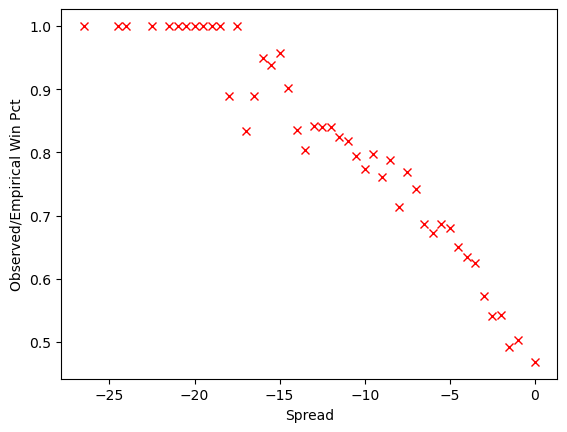

In [7]:
spreads = data.spread_favorite.unique()
spreads.sort()
num_spreads = len(spreads)
data["did_favorite_win"]=did_favorite_win
win_prob = [0 for i in range(num_spreads)]
for i in range(num_spreads):
    games_with_spread = data[data["spread_favorite"]==spreads[i]]
    num_games = games_with_spread.shape[0]
    wins_with_spread = games_with_spread[games_with_spread["did_favorite_win"]]
    win_prob[i]=wins_with_spread.shape[0]/num_games

plt.plot(spreads,win_prob,'rx')
plt.xlabel('Spread')
plt.ylabel('Observed/Empirical Win Pct')

Now it is time to build the logistic regression module. We'll use a train/test split 

In [8]:
spread_train, spread_test, win_flag_train,  win_flag_test = train_test_split(data["spread_favorite"],did_favorite_win)

spread_train=spread_train.values.reshape(-1,1) #this converts the list of scalars to a list of 1-typles for the model training
spread_test=spread_test.values.reshape(-1,1)

my_model = LogisticRegression()
my_model.fit(spread_train,win_flag_train)

LogisticRegression()

We can plot the curve against fake data now to see how the probability of winning depends on the spread!

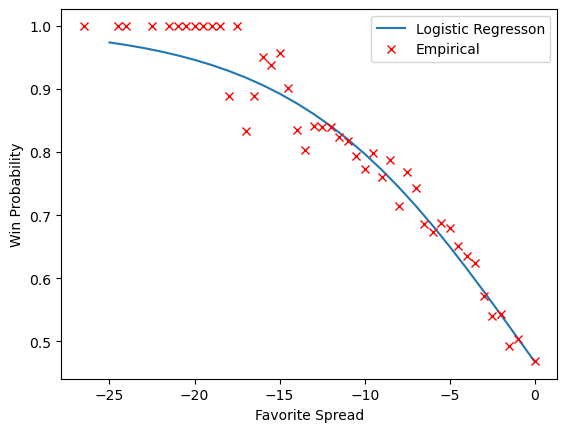

In [9]:
test_spreads = [[i-25] for i in range(26)]
model_out=my_model.predict_proba(test_spreads)

probs = model_out[:,1]
plt.figure()
plt.plot(test_spreads,probs,label='Logistic Regresson')
plt.plot(spreads,win_prob,'rx',label='Empirical')
plt.xlabel('Favorite Spread')
plt.ylabel('Win Probability')
plt.legend(loc='best')